In [4]:
import pandas as pd
import numpy as np
from math import *
import datetime
import yfinance as yf
from backtester_poo_272_mcd.strategies import LowVolatilityStrategy
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## I. Data import

[*********************100%***********************]  1 of 1 completed


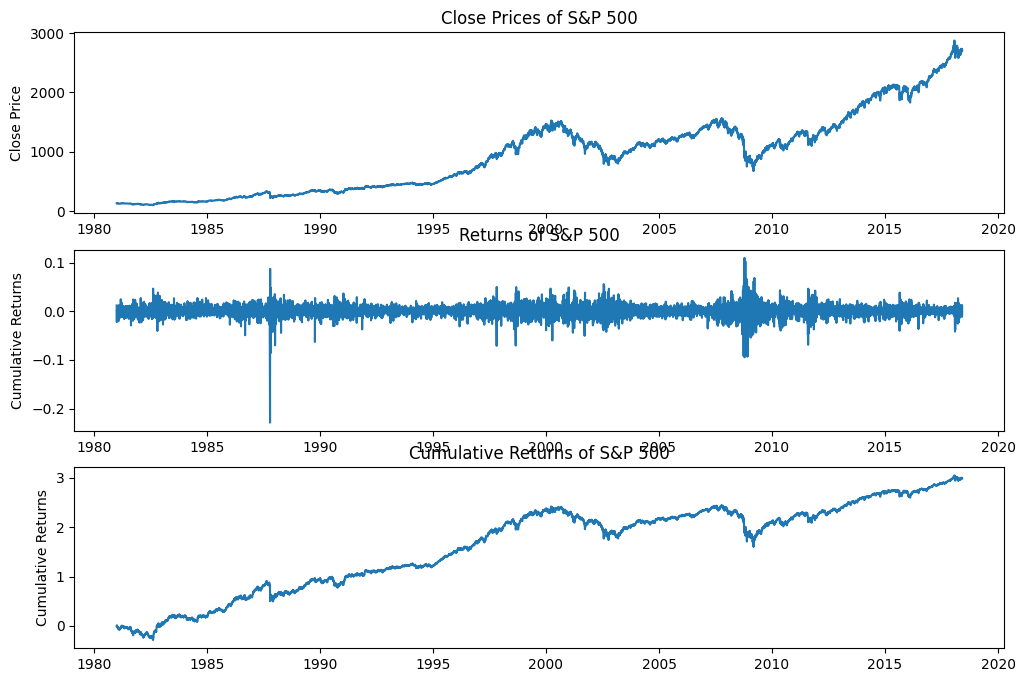

In [5]:
# Dictionary of index tickers
index_tickers = {
    "S&P 500": "^GSPC",
    "S&P 400 Midcap": "^SP400",
    "Nasdaq 100": "^NDX",
    "ASX 200": "^AXJO",
    "TSX": "^GSPTSE",
    "Euro Stoxx 600": "^STOXX",
    "Nikkei 225": "^N225",
    "JSE All-Share": "^J203",
    "FTSE 100": "^FTSE"
}

# Start and end dates
start_date = "1981-01-01"
end_date = "2018-06-01"

# Download S&P 500 data between start_date and end_date
sp500_data = yf.download(index_tickers["S&P 500"], start=start_date, end=end_date)['Close']

# Reset the index and rename the columns
sp500_data = sp500_data.reset_index().rename_axis('t', axis=1)
sp500_data = sp500_data.rename(columns={index_tickers["S&P 500"]: "Close"})

# Compute the cumulative returns
sp500_data['Cumulative Returns'] = np.log(sp500_data['Close'] / sp500_data['Close'].iloc[0])
sp500_data['Returns'] = sp500_data['Cumulative Returns'].diff()

'''sp500_data['Returns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data['a'] = sp500_data['Returns'].cumsum()
sp500_data['test'] = round(sp500_data['a'], 6) == round(sp500_data['Cumulative Returns'], 6)'''

# Plot the close prices and cumulative returns
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].plot(sp500_data['Date'], sp500_data['Close'])
ax[0].set_title("Close Prices of S&P 500")
ax[0].set_ylabel("Close Price")
ax[1].plot(sp500_data['Date'], sp500_data['Returns'])
ax[1].set_title("Returns of S&P 500")
ax[1].set_ylabel("Cumulative Returns")
ax[2].plot(sp500_data['Date'], sp500_data['Cumulative Returns'])
ax[2].set_title("Cumulative Returns of S&P 500")
ax[2].set_ylabel("Cumulative Returns")
plt.show()

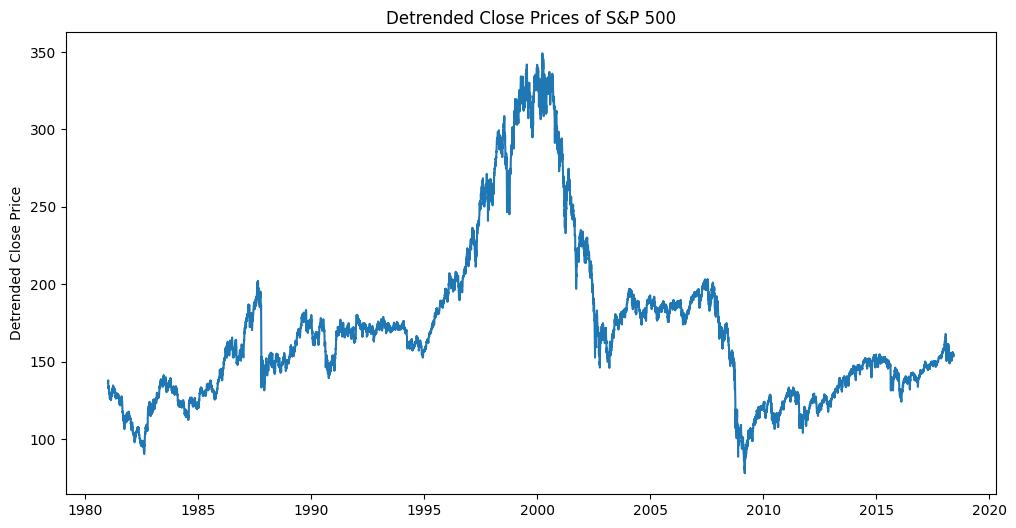

In [6]:
from scipy.stats import norm

# OLS regression (cumulated_return = cst + avg_daily_return * t => y = beta[0] + beta[1] * X)
cst_ones = np.ones((len(sp500_data[1:]), 1))
t = sp500_data.index[1:].to_numpy().reshape(-1, 1)
X = np.column_stack((cst_ones, t))
y = sp500_data['Cumulative Returns'][1:].to_numpy().reshape(-1,1)

# Using the beta formula
beta = np.linalg.inv(X.T @ X) @ X.T @ y

# Detrend the close prices
sp500_data['Detrended Close'] = sp500_data['Close'] / np.exp(beta[1] * sp500_data.index)

# Plot the detrended close prices (to do on stock prices)
plt.figure(figsize=(12, 6))
plt.plot(sp500_data['Date'], sp500_data['Detrended Close'])
plt.title("Detrended Close Prices of S&P 500")
plt.ylabel("Detrended Close Price")
plt.show()

In [7]:
tickers = ["MMM", "MO", "AXP", "AMGN", "AAPL", "T", "BA", "BMY", "CAT", "CVX", "CSCO", "KO", "CL", "COP", "COST", "DIS", "XOM", "F", "GE", "GM", "GS", "HD", "HON", "INTC", "IBM", "JNJ", "JPM", "LMT", "LOW", "MCD", "MRK", "MSFT", "MS", "NKE", "PEP", "PFE", "PG", "RTX", "SO", "TGT", "TXN", "UPS", "UNH", "VZ", "WBA", "WMT", "WFC"]

start_date = "1993-01-01"
end_date = "2018-06-01"
# Download the data for the tickers
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna(axis=1)

[*********************100%***********************]  47 of 47 completed


In [8]:
valid_tickers = data.columns

# Detrend the stock prices
detrend_factor = np.exp(-beta[1] * np.arange(len(data)).reshape(-1, 1))
detrended_data = data * detrend_factor

'''# Plot the detrended stock prices
plt.figure(figsize=(12, 6))
plt.plot(detrended_data.iloc[:,0], label='Detrended')
plt.plot(data.iloc[:,0], label='Original')
plt.title("Detrended Stock Prices")
plt.show()'''


'# Plot the detrended stock prices\nplt.figure(figsize=(12, 6))\nplt.plot(detrended_data.iloc[:,0], label=\'Detrended\')\nplt.plot(data.iloc[:,0], label=\'Original\')\nplt.title("Detrended Stock Prices")\nplt.show()'

## II. Sentiment Index

In [20]:
# Length of the time window measured in days
L = 100

# Weight used to compute the EMA
W = 2 / (L + 1)

# Initialize the EMA with the first value (SMA)
ema_data = pd.DataFrame(index=data.index, columns=data.columns)
ema_data.iloc[L] = np.sum(data[:L], axis=0) / L

for row in range(L+1, len(ema_data)):
    ema_data.iloc[row] = W * data.iloc[row] + (1 - W) * ema_data.iloc[row-1]

# We have to drop the first L rows since they are used to compute the first EMA value
data = data[L:]
ema_data = ema_data[L:]


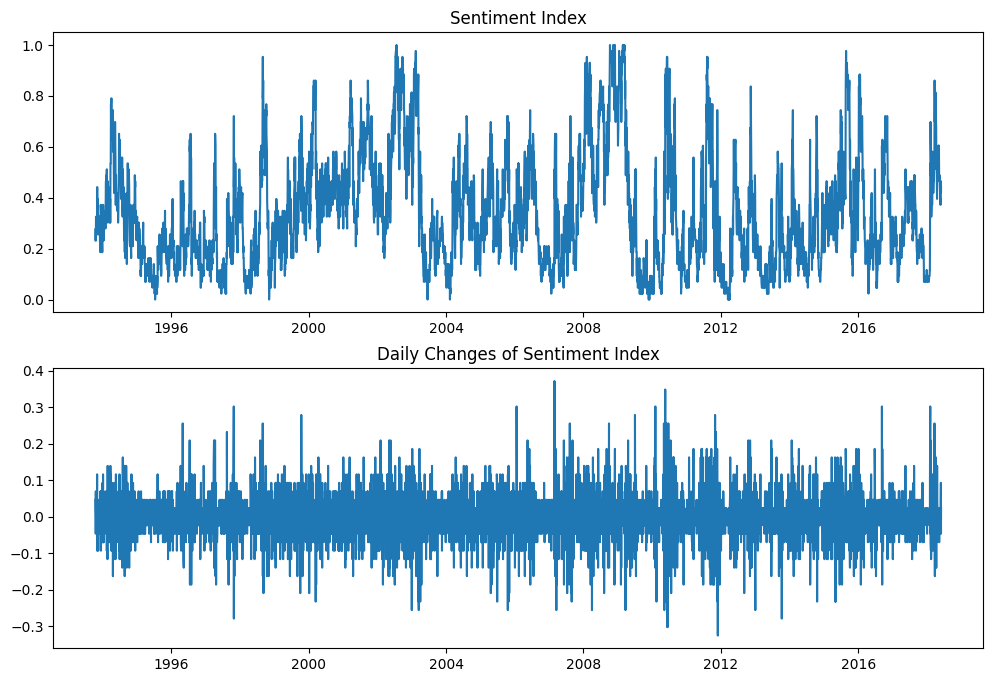

In [29]:
# A stock is in a pessimistic state if its price is below its EMA
pessimistic_state = data < ema_data
agg_pessimistic_state = pessimistic_state.sum(axis=1)

# Compute the sentiment index and the daily changes
sentiment_index = agg_pessimistic_state / pessimistic_state.shape[1]
daily_changes_sentiment_index = sentiment_index.diff()

# Plot the sentiment index and the daily changes
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(sentiment_index)
ax[0].set_title("Sentiment Index")
ax[1].plot(daily_changes_sentiment_index)
ax[1].set_title("Daily Changes of Sentiment Index")
plt.show()

In [18]:
sentiment_index

Date
1993-05-26    0.744186
1993-05-27    0.720930
1993-05-28    0.720930
1993-06-01    0.767442
1993-06-02    0.744186
                ...   
2018-05-24    0.604651
2018-05-25    0.627907
2018-05-29    0.534884
2018-05-30    0.581395
2018-05-31    0.558140
Length: 6300, dtype: float64